In [220]:
import pandas as pd
from pandas.tseries.offsets import BDay
import numpy as np
import matplotlib.pyplot as plt
import psycopg2 as pg
from scipy import stats
from cmdstanpy import CmdStanModel
import arviz as az
import statsmodels.api as sm

from config import DATABASE_URI

plt.rcParams["figure.figsize"] = (15,10)

# Data

In [221]:
with pg.connect(DATABASE_URI) as conn:
    with conn.cursor() as cur:
        cur.execute("SELECT date, close FROM prices WHERE frequency='MINUTE' AND ticker='^GSPC'")
        result = cur.fetchall()
    
data = pd.DataFrame.from_records(result, columns=["date", "close"], coerce_float=True, index="date").squeeze()

# Daily realized volatility estimator from intraday data
results = {}
for idx, day in data.groupby(data.index.date):
    results[idx] = np.sum(np.square(np.log(day) - np.log(day.shift(1))))

vol = pd.Series(results)
vol = vol.reindex(pd.to_datetime(vol.index))
wk_vol = np.sqrt(vol.rolling(5).sum().dropna())

In [222]:
with pg.connect(DATABASE_URI) as conn:
    with conn.cursor() as cur:
        cur.execute("SELECT ticker, date, close FROM prices WHERE frequency='DAILY' AND ticker IN ('^GSPC', '^VIX')")
        result = cur.fetchall()

data = pd.DataFrame.from_records(result, columns=["ticker", "date", "close"], coerce_float=True, index="date")
data = data.sort_index()

spx = data[data["ticker"] == "^GSPC"]["close"]
vix = data[data["ticker"] == "^VIX"]["close"]
# Transform VIX to same scale as weekly volatility
vix = vix / np.sqrt(252/5) / 100

# Multiple returns by 100 so the are vaguely same scale as log volatility
spx_wk_returns = (np.log(spx) - np.log(spx.shift(5))).dropna() * 100

In [223]:
# Input features construction
x = pd.DataFrame(index=wk_vol.index)
# Realized volatility from last 4 weekly periods
x["RV-1"] = np.log(wk_vol)
x["RV-2"] = np.log(wk_vol.shift(5))
x["RV-3"] = np.log(wk_vol.shift(10))
x["RV-4"] = np.log(wk_vol.shift(15))
# End of week VIX level
x["VIX"] = np.log(vix)
# SPX returns from previous 4 weeks
x["SPX-1"] = spx_wk_returns
x["SPX-2"] = spx_wk_returns.shift(5)
x["SPX-3"] = spx_wk_returns.shift(10)
x["SPX-4"] = spx_wk_returns.shift(15)
# Standard deviation of RV over past month
x["RV-VOL"] = np.log(wk_vol.rolling(21).std())
# RV moving average over varying lookbacks
x["RV-D"] = np.log(np.sqrt(vol))
x["RV-W"] = np.log(np.sqrt(vol.rolling(5).mean()))
x["RV-M"] = np.log(np.sqrt(vol.rolling(21).mean()))

# Calculates RV percentile rank.
# Percent of RV's in the last year that are below the last
# recorded RV value
rv_percentile = pd.Series(index=x.index, dtype=float)

for date in rv_percentile.index:
    # Get past year worth of RV data, if there isn't enough, skip
    wk_vol_interval = wk_vol.loc[date - BDay(252):date]
    if len(wk_vol_interval) < 240:
        continue
    rv_percent = stats.percentileofscore(wk_vol_interval, wk_vol.loc[date])
    rv_percentile.loc[date] = rv_percent
# 1-year RV rank
x["RV-PERCENT"] = np.log(rv_percentile)

In [224]:
x = x.dropna()
# Forecasting objective: 1 week forward RV
y = np.log(wk_vol.shift(-5).dropna())

common_index = x.index.intersection(y.index)

split = int(0.80 * len(common_index))
x_train = x.loc[common_index[:split]]
y_train = y.loc[common_index[:split]]
x_test = x.loc[common_index[split:]]
y_test = y.loc[common_index[split:]]

# Model

In [226]:
model_spec = """
data {
    int N;  // Length of data
    int M;  // Number of features
    vector[N] y;  // Forecast objective
    matrix[N, M] x;  // Features matrix
    
    int N_hat;  // OOS length
    matrix[N_hat, M] x_hat;  // OOS input features
    
    vector[M] x_t;  // Input features for forecast
}
parameters {
    real mu;
    real<lower=0> sigma;
    real<lower=0> rho;
    vector[M] beta;
}
model {
    mu ~ normal(0, 10);
    sigma ~ normal(0, 10);
    rho ~ normal(0, 5);
    beta ~ normal(0, rho);
    y ~ normal(mu + x * beta, sigma);
}
generated quantities {
    real y_tilde[N];  // In-sample Posterior predictive
    real y_hat[N_hat];  // OOS posterior predictive
    real y_t;  // Forward forecast
    y_tilde = exp(normal_rng(mu + x * beta, sigma));  // Inverse log transform for all
    y_hat = exp(normal_rng(mu + x_hat * beta, sigma));
    y_t = exp(normal_rng(mu + dot_product(x_t, beta), sigma));
}
"""

In [227]:
with open("./stan_model/RV_model.stan", "w") as file:
    file.write(model_spec)

model = CmdStanModel(stan_file="./stan_model/RV_model.stan")
data = {
    "N": len(x_train),
    "M": len(x_train.columns),
    "y": y_train.values,
    "x": x_train.values,
    "N_hat": len(x_test),
    "x_hat": x_test.values,
    "x_t": x.iloc[-1].values
}
sample = model.sample(data=data, chains=4, parallel_chains=4, iter_warmup=500, iter_sampling=2500)

INFO:cmdstanpy:compiling stan program, exe file: /home/eadains/VolatilityTrading/stan_model/RV_model
INFO:cmdstanpy:compiler options: stanc_options=None, cpp_options=None
INFO:cmdstanpy:compiled model file: /home/eadains/VolatilityTrading/stan_model/RV_model
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 2


### In sample performance

In [228]:
# Inverse log transform on observed data
model_data = az.from_cmdstanpy(posterior=sample, posterior_predictive="y_tilde",
                               observed_data={"y": np.exp(y_train.values)}, predictions="y_hat")

array([[<AxesSubplot:title={'center':'mu'}>,
        <AxesSubplot:title={'center':'mu'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>],
       [<AxesSubplot:title={'center':'rho'}>,
        <AxesSubplot:title={'center':'rho'}>],
       [<AxesSubplot:title={'center':'beta'}>,
        <AxesSubplot:title={'center':'beta'}>]], dtype=object)

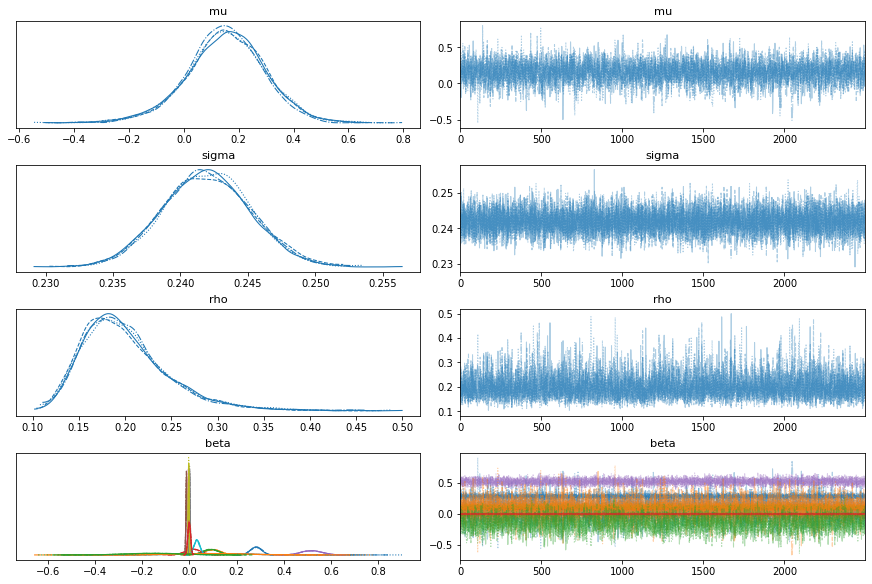

In [229]:
az.plot_trace(model_data, compact=True, var_names=["mu", "sigma", "rho", "beta"])

In [230]:
y_tilde = model_data.posterior_predictive.y_tilde.values.reshape(10000, -1)
mean = np.mean(y_tilde, axis=1)
std = np.std(y_tilde, axis=1)
skew = stats.skew(y_tilde, axis=1)
kurt = stats.kurtosis(y_tilde, axis=1)

Text(0.5, 1.0, 'Kurtosis')

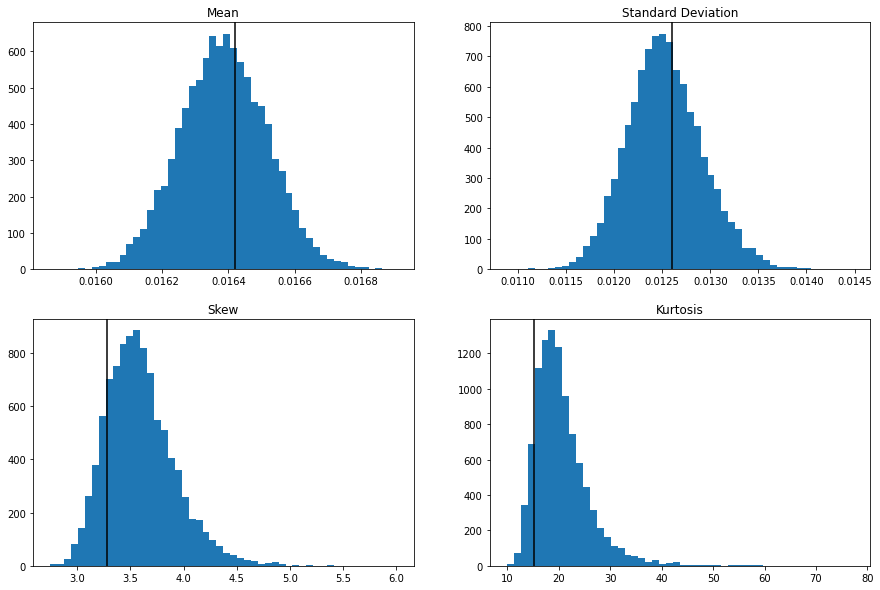

In [231]:
fig, axs = plt.subplots(2, 2)
axs[0, 0].hist(mean, bins=50)
axs[0, 0].axvline(np.mean(model_data.observed_data.y.values), color='black')
axs[0, 0].set_title("Mean")
axs[0, 1].hist(std, bins=50)
axs[0, 1].axvline(np.std(model_data.observed_data.y.values), color='black')
axs[0, 1].set_title("Standard Deviation")
axs[1, 0].hist(skew, bins=50)
axs[1, 0].axvline(stats.skew(model_data.observed_data.y.values), color='black')
axs[1, 0].set_title("Skew")
axs[1, 1].hist(kurt, bins=50)
axs[1, 1].axvline(stats.kurtosis(model_data.observed_data.y.values), color='black')
axs[1, 1].set_title("Kurtosis")

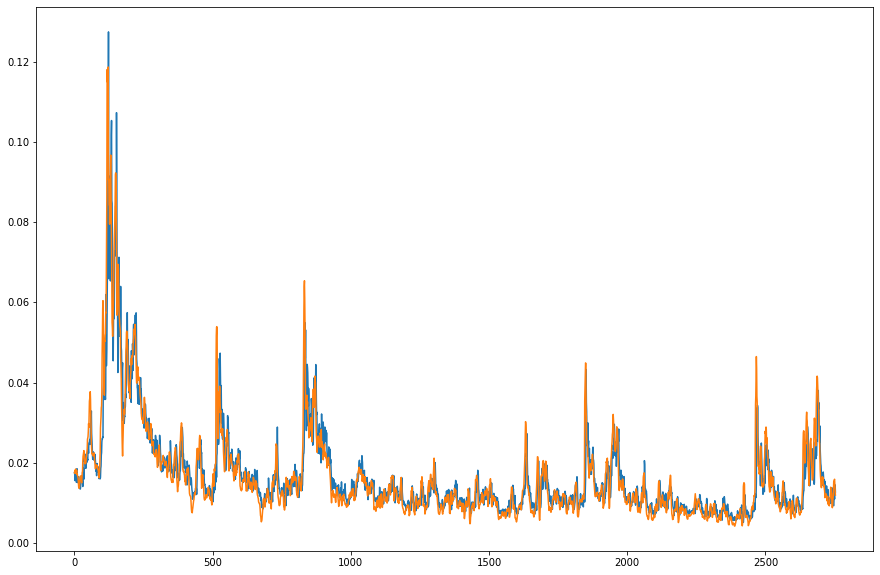

In [232]:
point_forecast_train = np.mean(y_tilde, axis=0)
plt.plot(point_forecast_train)
plt.plot(model_data.observed_data.y.values)

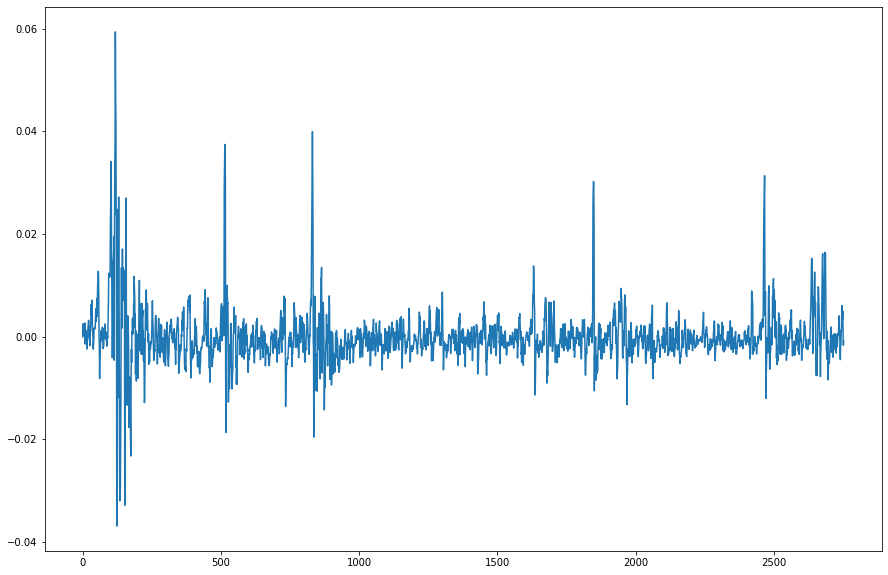

In [233]:
residuals = model_data.observed_data.y.values - point_forecast_train
plt.plot(residuals)

In [234]:
RMSE_train = np.sqrt(np.mean((point_forecast_train - model_data.observed_data.y.values)**2))
RMSE_train

0.005426507225398834

In [235]:
regress = stats.linregress(point_forecast_train, model_data.observed_data.y.values)
print(f'Intercept: {regress.intercept} \nSlope: {regress.slope} \nR-Squared: {regress.rvalue**2}')

Intercept: 0.00024121002533587788 
Slope: 0.9872703831086298 
R-Squared: 0.8145740599008288


In [236]:
exceedances = {}
for f in [1, 5, 10, 25, 50, 75, 90, 95, 99]:
    percent_exceed = np.sum(model_data.observed_data.y.values < np.percentile(y_tilde, f, axis=0)) / len(model_data.observed_data.y.values)
    exceedances[f] = round(percent_exceed * 100)
exceedances

{1: 1, 5: 3, 10: 8, 25: 24, 50: 52, 75: 80, 90: 91, 95: 95, 99: 98}

In [237]:
values = []

for t in range(len(model_data.observed_data.y.values)):
    ecdf = sm.distributions.empirical_distribution.ECDF(y_tilde[:, t])
    values.append(ecdf(model_data.observed_data.y.values[t]))

/home/eadains/VolatilityTrading/venv/lib/python3.8/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


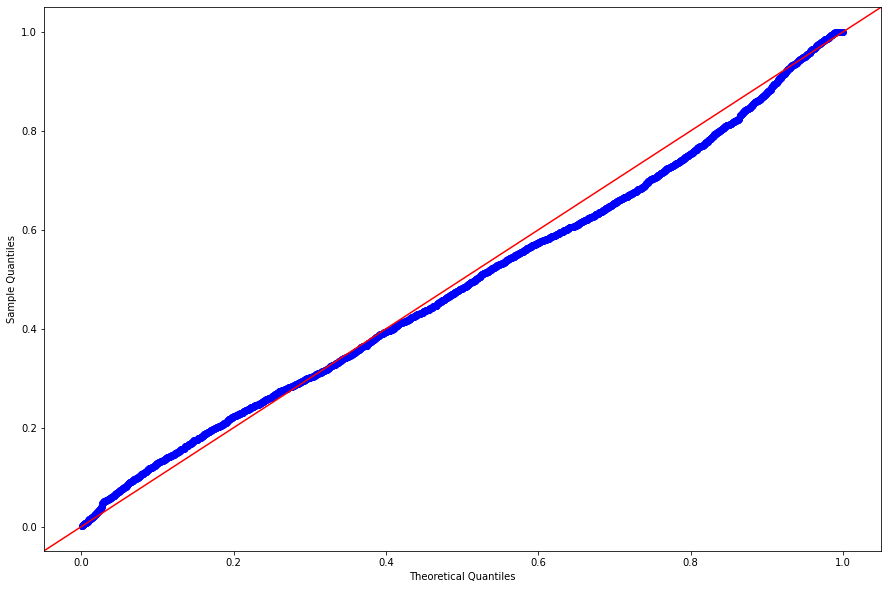

In [238]:
fig = sm.graphics.qqplot(np.array(values), dist=stats.uniform, line="45")

In [239]:
stats.kstest(values, "uniform")

KstestResult(statistic=0.05156209150326796, pvalue=8.377247839062459e-07)

### Out of sample performance

In [132]:
y_hat = model_data.predictions.y_hat.values.reshape(10000, -1)
mean = np.mean(y_hat, axis=1)
std = np.std(y_hat, axis=1)
skew = stats.skew(y_hat, axis=1)
kurt = stats.kurtosis(y_hat, axis=1)

Text(0.5, 1.0, 'Kurtosis')

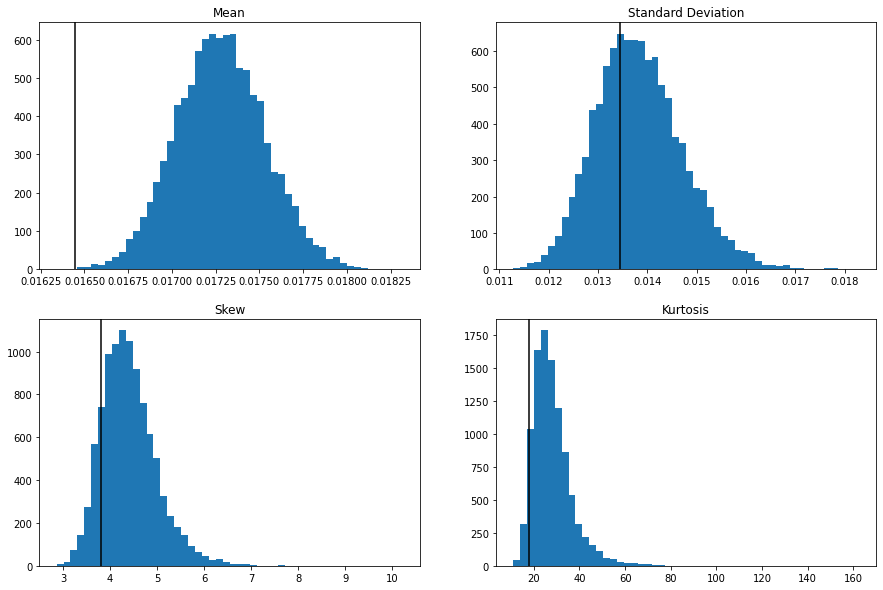

In [133]:
fig, axs = plt.subplots(2, 2)
axs[0, 0].hist(mean, bins=50)
axs[0, 0].axvline(np.mean(np.exp(y_test)), color='black')
axs[0, 0].set_title("Mean")
axs[0, 1].hist(std, bins=50)
axs[0, 1].axvline(np.std(np.exp(y_test)), color='black')
axs[0, 1].set_title("Standard Deviation")
axs[1, 0].hist(skew, bins=50)
axs[1, 0].axvline(stats.skew(np.exp(y_test)), color='black')
axs[1, 0].set_title("Skew")
axs[1, 1].hist(kurt, bins=50)
axs[1, 1].axvline(stats.kurtosis(np.exp(y_test)), color='black')
axs[1, 1].set_title("Kurtosis")

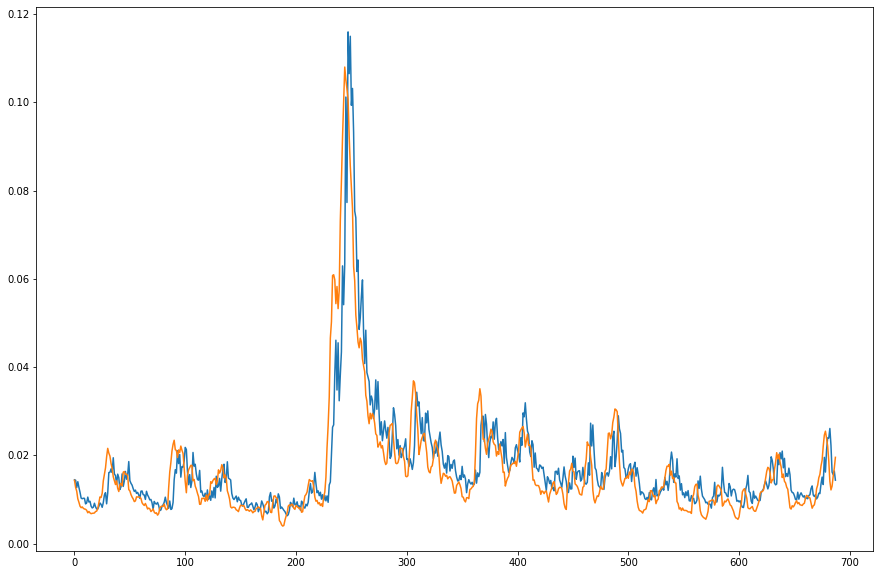

In [165]:
point_forecast_test = np.mean(y_hat, axis=0)
plt.plot(point_forecast_test)
plt.plot(np.exp(y_test.values))

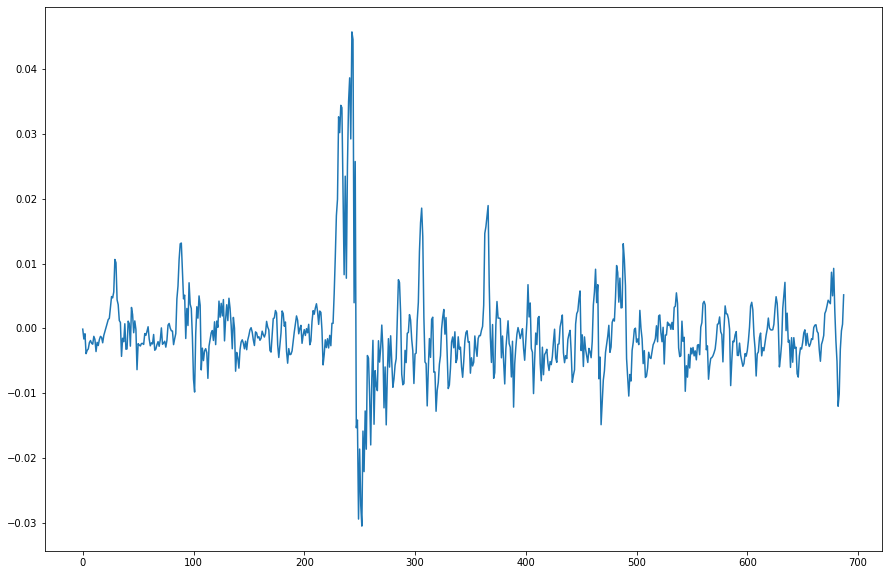

In [166]:
residuals = np.exp(y_test.values) - point_forecast_test
plt.plot(residuals)

In [167]:
RMSE_test = np.sqrt(np.mean((point_forecast_test - np.exp(y_test))**2))
print(f"Test RMSE: {RMSE_test}\nDecrease in performance: {((RMSE_test / RMSE_train)-1)*100}%")

Test RMSE: 0.007035271729105925
Decrease in performance: 29.591422946288716%


In [168]:
regress = stats.linregress(point_forecast_test, np.exp(y_test))
print(f'Intercept: {regress.intercept} \nSlope: {regress.slope} \nR-Squared: {regress.rvalue**2}')

Intercept: 0.0008440516514631822 
Slope: 0.9029998638685921 
R-Squared: 0.7386778559563965


In [190]:
exceedances = {}
for f in [1, 5, 10, 25, 50, 75, 90, 95, 99]:
    percent_exceed = np.sum(np.exp(y_test) < np.percentile(y_hat, f, axis=0)) / len(y_test)
    exceedances[f] = round(percent_exceed * 100)
exceedances

{1: 4, 5: 10, 10: 18, 25: 40, 50: 62, 75: 80, 90: 89, 95: 93, 99: 97}

In [211]:
values = []

for t in range(len(y_test)):
    ecdf = sm.distributions.empirical_distribution.ECDF(y_hat[:, t])
    values.append(ecdf(np.exp(y_test[t])))

/home/eadains/VolatilityTrading/venv/lib/python3.8/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


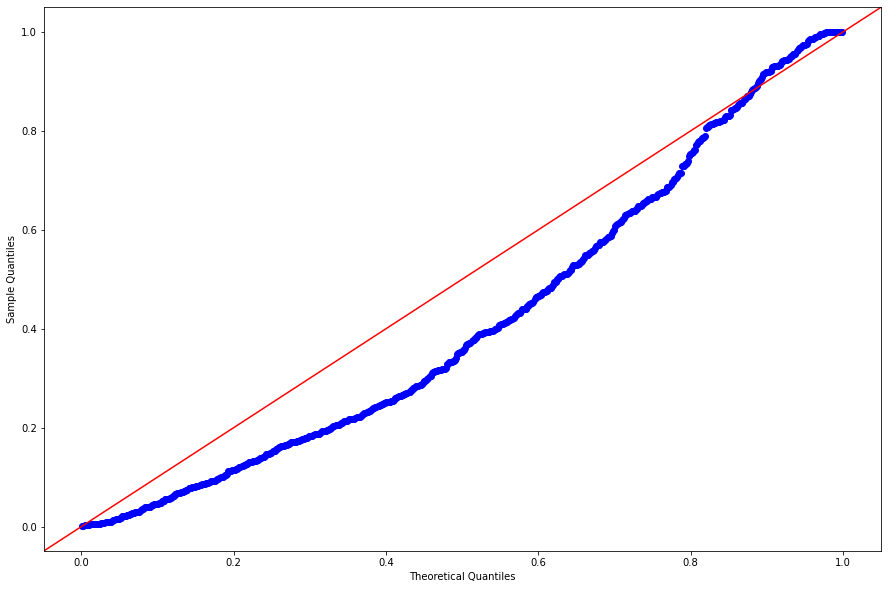

In [212]:
# Forecasted distribution has higher skew than the emprical data
fig = sm.graphics.qqplot(np.array(values), dist=stats.uniform, line="45")

In [214]:
stats.kstest(values, "uniform")

KstestResult(statistic=0.16018604651162788, pvalue=6.867102592267086e-16)

# Forecast

In [271]:
forecast = model_data.posterior.y_t.values.reshape(10000)

In [274]:
print(f"""Date: {str(x.index[-1].date())}
Forecasted Volatility: {round(np.mean(forecast) * np.sqrt(252/5) * 100, 2)}%
  5%: {round(np.percentile(forecast, 5) * np.sqrt(252/5) * 100, 2)}%
  95%: {round(np.percentile(forecast, 95) * np.sqrt(252/5) * 100, 2)}%
  99%: {round(np.percentile(forecast, 99) * np.sqrt(252/5) * 100, 2)}%""")

Date: 2021-12-23
Forecasted Volatility: 9.37%
  5%: 6.11%
  95%: 13.53%
  99%: 15.75%


In [309]:
# Average gap between VIX and RV over the last year
current_iv = 11.1
current_vix = 17.98
vix_gap = (vix * np.sqrt(252/5) * 100) - (wk_vol * np.sqrt(252/5) * 100)
print(f"Mean VIX-RV gap: {round(vix_gap[-252:].mean(), 2)}%")
print(f"Current gap: {round(current_vix - (np.mean(forecast) * np.sqrt(252/5) * 100), 2)}%")

Mean VIX-RV gap: 10.69%
Current gap: 8.61%


In [316]:
# Percent of days that fall below current value
print(f"Current IV vs 1 year RV: {round(stats.percentileofscore((wk_vol * np.sqrt(252/5) * 100)[-252:], current_iv), 2)}%")
print(f"Current IV vs forecast: {round(stats.percentileofscore(forecast * 100 * np.sqrt(252/5), current_iv), 2)}%")

Current IV vs 1 year RV: 75.4%
Current IV vs forecast: 79.52%


In [334]:
# Weekly returns adjusted by weekly volatility. Past year only
normed_returns = (spx_wk_returns / 100 / wk_vol)[-252:].dropna()
# Bootstrap sample of normalized returns scaled by the forecast of future volatility
forecasted_returns = np.random.choice(normed_returns, 10000) * forecast
forecasted_prices = spx.loc[x.index[-1]] * (1 + forecasted_returns)

In [335]:
short_put_strike = 4625
short_call_strike = 4795
premium = 130
max_loss = 500
pop = 100 - (stats.percentileofscore(forecasted_prices, short_put_strike) + (100 - stats.percentileofscore(forecasted_prices, short_call_strike)))
pop /= 100
print(f"Probability of profit: {pop * 100}%")
print(f"Expected Value: {(pop * premium) - ((1-pop) * max_loss)}")

Probability of profit: 64.89%
Expected Value: -91.19299999999998
